In [16]:
import numpy as np
import math 
import pandas as pd
from pandas.io.json import json_normalize
import json
import sys  
sys.path.insert(0, './scripts')
from PricingModels import *


trades = []
run_matrix=[]
cols = ["init.apy","init.percent_fee","init.days_until_maturity","init.max_order_size","init.time_stretch",\
        "init.market_price","init.target_liquidity","init.target_daily_volume","input.day","input.time",\
        "input.base_market_price", "input.unit_fyt_price","input.base_reserves","input.fyt_reserves",\
        "input.token_in","input.amount_specified","input.token_out","input.direction",\
        "output.trade_volume","output.fee","output.slippage"]

ybas = [
    {
        "vault" : "ycrvSTETH",
        "apy" : 20,
        "market_price" : 2000,
        "time_stretch": 3,
        "days_until_maturity": 90,
    },
    {
        "vault" : "ycrvSTETH",
        "apy" : 20,
        "market_price" : 2000,
        "time_stretch": 5,
        "days_until_maturity": 90,
    },
]


for target_daily_volume in [5000000,10000000]:
    for target_liquidity in [5000000]:
        for g in [.1]:
                for yba in ybas:
                    np.random.seed(2)
                    APY=yba["apy"]
                    days_until_maturity = yba["days_until_maturity"]
                    market_price = yba["market_price"]
                    time_stretch = yba["time_stretch"]
                    run_matrix.append((yba,g,target_liquidity,target_daily_volume))

                    y_start = target_liquidity/market_price
                    max_order_price=12500
                    max_order_size=max_order_price/market_price 
                    sigma=max_order_size/10
                    liquidity = 0
                    
                    # dirty hack to ensure that we dont overshoot the target liquidity
                    while True:
                        x_start = Element_Pricing_Model.calc_x_reserves(APY,y_start,days_until_maturity,time_stretch)
                        total_supply=x_start
                        t=days_until_maturity/(365*time_stretch)
                        liquidity=x_start*market_price+y_start*market_price*m.fyt_price()
                        if liquidity > target_liquidity:
                            y_start-=10
                        else:
                            break
                    
                    step_size=t/days_until_maturity
                    epsilon=step_size/2
                    m = Market(x_start,y_start,g,t,total_supply,Element_Pricing_Model)
                    print("Days Until Maturity: " + str(days_until_maturity))
                    print("Time Stretch: " + str(time_stretch))
                    print("Fee %: " + str(g*100))
                    print("Max order size: " + str(max_order_size))
                    print("Starting APY: {:.2f}%".format(m.apy(days_until_maturity)))
                    print("Starting FYT Price: " + str(m.fyt_price()))
                    print("Starting Liquidity: ${:,.2f}".format(liquidity))
                    print("Starting Base Reserves: " + str(m.x))
                    print("Starting FYT Reserves: " + str(m.y))
                    x_orders=0
                    x_volume=0
                    y_orders=0
                    y_volume=0

                    total_fees = 0
                    todays_volume = 0
                    todays_fees = 0
                    todays_num_trades = 0
                    day=0
                    while m.t > epsilon:
                        day += 1
                        todays_volume = 0
                        todays_fees = 0
                        todays_num_trades = 0
                        maturity_ratio = day/days_until_maturity
                        ub=target_daily_volume*math.log10(1/maturity_ratio) # log(1/maturity ratio) is used to simulate waning demand over the lifetime of the fyt
                        todays_target_volume = np.random.uniform(ub/2,ub)
                        while todays_target_volume > todays_volume:
                            fee = -1
                            trade = []
                            while fee < 0:
                                # determine order size
                                amount = np.random.normal(max_order_size/2,sigma)
                                lb_amount = max(0.00001,amount)
                                amount = min(max_order_size,lb_amount)
                                # buy fyt or base
                                if np.random.uniform(0,1) < 0.5:
                                    token_in = "base"
                                    token_out = "fyt"
                                else:
                                    token_in = "fyt"
                                    token_out = "base"

                                if np.random.uniform(0,1) < 0.5:
                                    direction="in"
                                else:
                                    direction="out"
                                    

                                start_x_volume = m.x_volume
                                start_y_volume = m.y_volume
                                (without_fee_or_slippage,with_fee,without_fee,fee) = m.swap(amount,direction,token_in,token_out)
                                
                                trade = [APY,g,days_until_maturity,max_order_size,time_stretch,market_price,target_liquidity,target_daily_volume,day,m.t,market_price,m.fyt_price(),m.x,m.y,token_in,amount,token_out,direction,with_fee*market_price,fee*market_price,(without_fee_or_slippage-without_fee)*market_price]
                                
                            trades.append(trade);
                            todays_volume += (m.x_volume - start_x_volume)*market_price + (m.y_volume - start_y_volume)*market_price
                            todays_fees += fee*market_price
                            todays_num_trades += 1
                        print("\tDay: " + str(day) + " FYT Price: " + str(m.fyt_price()) + " Implied APY: " + str(m.apy(days_until_maturity-day+1)) + " Target Volume Factor: {:,.4f}".format(math.log10(1/maturity_ratio)) + " Volume: ${:,.2f}".format(todays_volume) + " Num Trades: " + str(todays_num_trades) + " Fees: ${:,.2f}".format(todays_fees))
                        total_fees += todays_fees
                        m.tick(step_size)

                    print("Ending Liquidity: ${:,.2f}".format(m.x*market_price+m.y*market_price*m.fyt_price()))
                    print("Total volume: ${:,.2f}".format(m.x_volume*market_price+m.y_volume*market_price))
                    print("Total fees: ${:,.2f}".format(total_fees))
                    print("Ending Base Reserves: " + str(m.x))
                    print("Delta Base Reserves: " + str(abs(x_start-m.x)))
                    print("Ending FYT Reserves: " + str(m.y))
                    print("Delta FYT Reserves: " + str(abs(y_start-m.y)))
                    print("Num base orders: " + str(m.x_orders))
                    print("Cum base volume: " + str(m.x_volume))
                    print("Num FYT orders: " + str(m.y_orders))
                    print("Cum FYT volume: " + str(m.y_volume))
                    print("Cum slippage Base: " + str(m.cum_x_slippage))
                    print("Cum slippage FYT: " + str(m.cum_y_slippage))
                    print("Cum fees Base: " + str(m.cum_x_fees))
                    print("Cum fees FYT: " + str(m.cum_y_fees))
                    print("Ending FYT Price: " + str(m.fyt_price()))
                    print("Ending Time: " + str(m.t))
                    print("##################################################################")



#df = pd.DataFrame.from_dict(json_normalize(trades), orient='columns')
df = pd.DataFrame(trades,columns=cols)




Days Until Maturity: 90
Time Stretch: 3
Fee %: 10.0
Max order size: 6.25
Starting APY: 20.00%
Starting FYT Price: 0.9506849315068493
Starting Liquidity: $4,961,687.49
Starting Base Reserves: 1340.8437447535146
Starting FYT Reserves: 1140.0
	Day: 1 FYT Price: 0.9370731891687314 Implied APY: 25.52031772601449 Target Volume Factor: 1.9542 Volume: $7,024,173.71 Num Trades: 1131 Fees: $38,741.33
	Day: 2 FYT Price: 0.9501522323743614 Implied APY: 20.443185599278745 Target Volume Factor: 1.6532 Volume: $5,980,629.10 Num Trades: 958 Fees: $33,655.87
	Day: 3 FYT Price: 0.9512245199681487 Implied APY: 20.230738876847408 Target Volume Factor: 1.4771 Volume: $4,187,585.37 Num Trades: 667 Fees: $19,766.87
	Day: 4 FYT Price: 0.9417590258067706 Implied APY: 24.434431701757152 Target Volume Factor: 1.3522 Volume: $6,401,234.77 Num Trades: 1029 Fees: $35,854.52
	Day: 5 FYT Price: 0.9422878377616375 Implied APY: 24.494115368607343 Target Volume Factor: 1.2553 Volume: $5,751,813.64 Num Trades: 925 Fees: 

	Day: 55 FYT Price: 0.9658951508476159 Implied APY: 34.578527612833874 Target Volume Factor: 0.2139 Volume: $717,513.08 Num Trades: 115 Fees: $2,484.61
	Day: 56 FYT Price: 0.9670382092728411 Implied APY: 34.37443890117998 Target Volume Factor: 0.2061 Volume: $572,114.55 Num Trades: 86 Fees: $1,874.63
	Day: 57 FYT Price: 0.968594449575351 Implied APY: 33.71478207352023 Target Volume Factor: 0.1984 Volume: $642,208.86 Num Trades: 102 Fees: $2,075.64
	Day: 58 FYT Price: 0.969051214459188 Implied APY: 34.23123249211029 Target Volume Factor: 0.1908 Volume: $624,574.44 Num Trades: 100 Fees: $1,974.94
	Day: 59 FYT Price: 0.9717667849863127 Implied APY: 32.203510874987025 Target Volume Factor: 0.1834 Volume: $543,225.11 Num Trades: 88 Fees: $1,585.92
	Day: 60 FYT Price: 0.9723612625435253 Implied APY: 32.54238442455894 Target Volume Factor: 0.1761 Volume: $471,045.50 Num Trades: 76 Fees: $1,335.22
	Day: 61 FYT Price: 0.9746644862828373 Implied APY: 30.82487502254795 Target Volume Factor: 0.168

	Day: 27 FYT Price: 0.917231476806921 Implied APY: 47.20392338355289 Target Volume Factor: 0.5229 Volume: $2,193,213.52 Num Trades: 347 Fees: $19,870.01
	Day: 28 FYT Price: 0.9194236407206835 Implied APY: 46.68312878881035 Target Volume Factor: 0.5071 Volume: $1,295,598.37 Num Trades: 204 Fees: $11,331.23
	Day: 29 FYT Price: 0.9236131649413408 Implied APY: 44.969669026468715 Target Volume Factor: 0.4918 Volume: $1,540,908.70 Num Trades: 242 Fees: $12,240.09
	Day: 30 FYT Price: 0.9293514343412227 Implied APY: 42.27332207451428 Target Volume Factor: 0.4771 Volume: $1,806,548.33 Num Trades: 287 Fees: $13,497.96
	Day: 31 FYT Price: 0.9305225464893329 Implied APY: 42.265450885655845 Target Volume Factor: 0.4629 Volume: $2,212,934.48 Num Trades: 356 Fees: $16,425.59
	Day: 32 FYT Price: 0.9346172105613998 Implied APY: 40.44867482218488 Target Volume Factor: 0.4491 Volume: $1,878,185.66 Num Trades: 306 Fees: $13,052.40
	Day: 33 FYT Price: 0.9258698312723213 Implied APY: 46.650882044142655 Targ

	Day: 5 FYT Price: 0.9101489175906016 Implied APY: 38.134471022593516 Target Volume Factor: 1.2553 Volume: $6,904,802.05 Num Trades: 1098 Fees: $61,502.65
	Day: 6 FYT Price: 0.9226890843739874 Implied APY: 33.19821670999363 Target Volume Factor: 1.1761 Volume: $10,916,597.60 Num Trades: 1746 Fees: $97,119.37
	Day: 7 FYT Price: 0.9185661655038857 Implied APY: 35.384939989383 Target Volume Factor: 1.1091 Volume: $7,827,868.37 Num Trades: 1253 Fees: $64,817.66
	Day: 8 FYT Price: 0.9282254574871477 Implied APY: 31.563503635169994 Target Volume Factor: 1.0512 Volume: $5,602,533.10 Num Trades: 879 Fees: $41,899.31
	Day: 9 FYT Price: 0.9404529687275387 Implied APY: 26.505690749327286 Target Volume Factor: 1.0000 Volume: $5,325,955.62 Num Trades: 843 Fees: $33,930.65
	Day: 10 FYT Price: 0.9486614287220032 Implied APY: 23.134047551196087 Target Volume Factor: 0.9542 Volume: $4,952,811.97 Num Trades: 790 Fees: $28,400.56
	Day: 11 FYT Price: 0.946960169197271 Implied APY: 24.19942280374511 Target

	Day: 78 FYT Price: 0.9973468652455736 Implied APY: 7.449186041274156 Target Volume Factor: 0.0621 Volume: $614,257.26 Num Trades: 102 Fees: $157.47
	Day: 79 FYT Price: 0.9975475355747702 Implied APY: 7.459579293407427 Target Volume Factor: 0.0566 Volume: $324,222.13 Num Trades: 54 Fees: $79.18
	Day: 80 FYT Price: 0.9977720965412304 Implied APY: 7.392588749553518 Target Volume Factor: 0.0512 Volume: $320,310.52 Num Trades: 53 Fees: $75.26
	Day: 81 FYT Price: 0.9978949435529987 Implied APY: 7.6834560315548135 Target Volume Factor: 0.0458 Volume: $399,804.01 Num Trades: 64 Fees: $87.48
	Day: 82 FYT Price: 0.9983851493713275 Implied APY: 6.5491164385051555 Target Volume Factor: 0.0404 Volume: $252,010.83 Num Trades: 42 Fees: $44.54
	Day: 83 FYT Price: 0.9986312787473147 Implied APY: 6.244790715376585 Target Volume Factor: 0.0352 Volume: $293,427.33 Num Trades: 44 Fees: $42.16
	Day: 84 FYT Price: 0.9989081563099274 Implied APY: 5.693184955378801 Target Volume Factor: 0.0300 Volume: $224,23

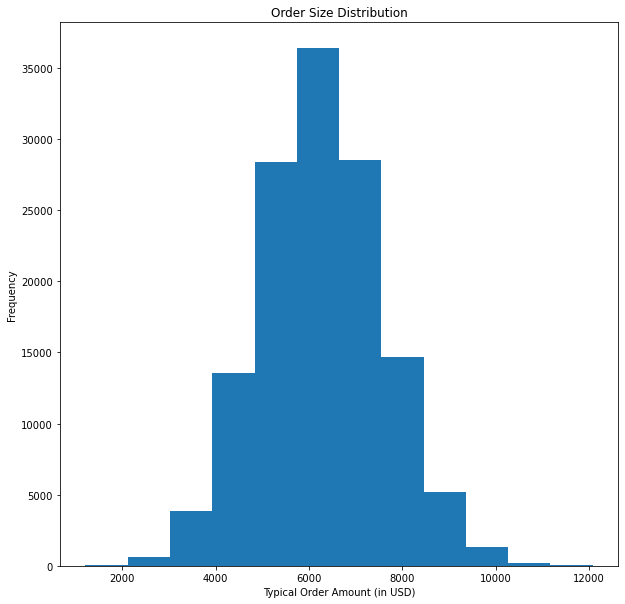

In [17]:
import matplotlib.pyplot as plt

hist=df['output.trade_volume'].plot.hist(bins=12,title="Order Size Distribution",figsize=(10,10));
hist=hist.set_xlabel("Typical Order Amount (in USD)")

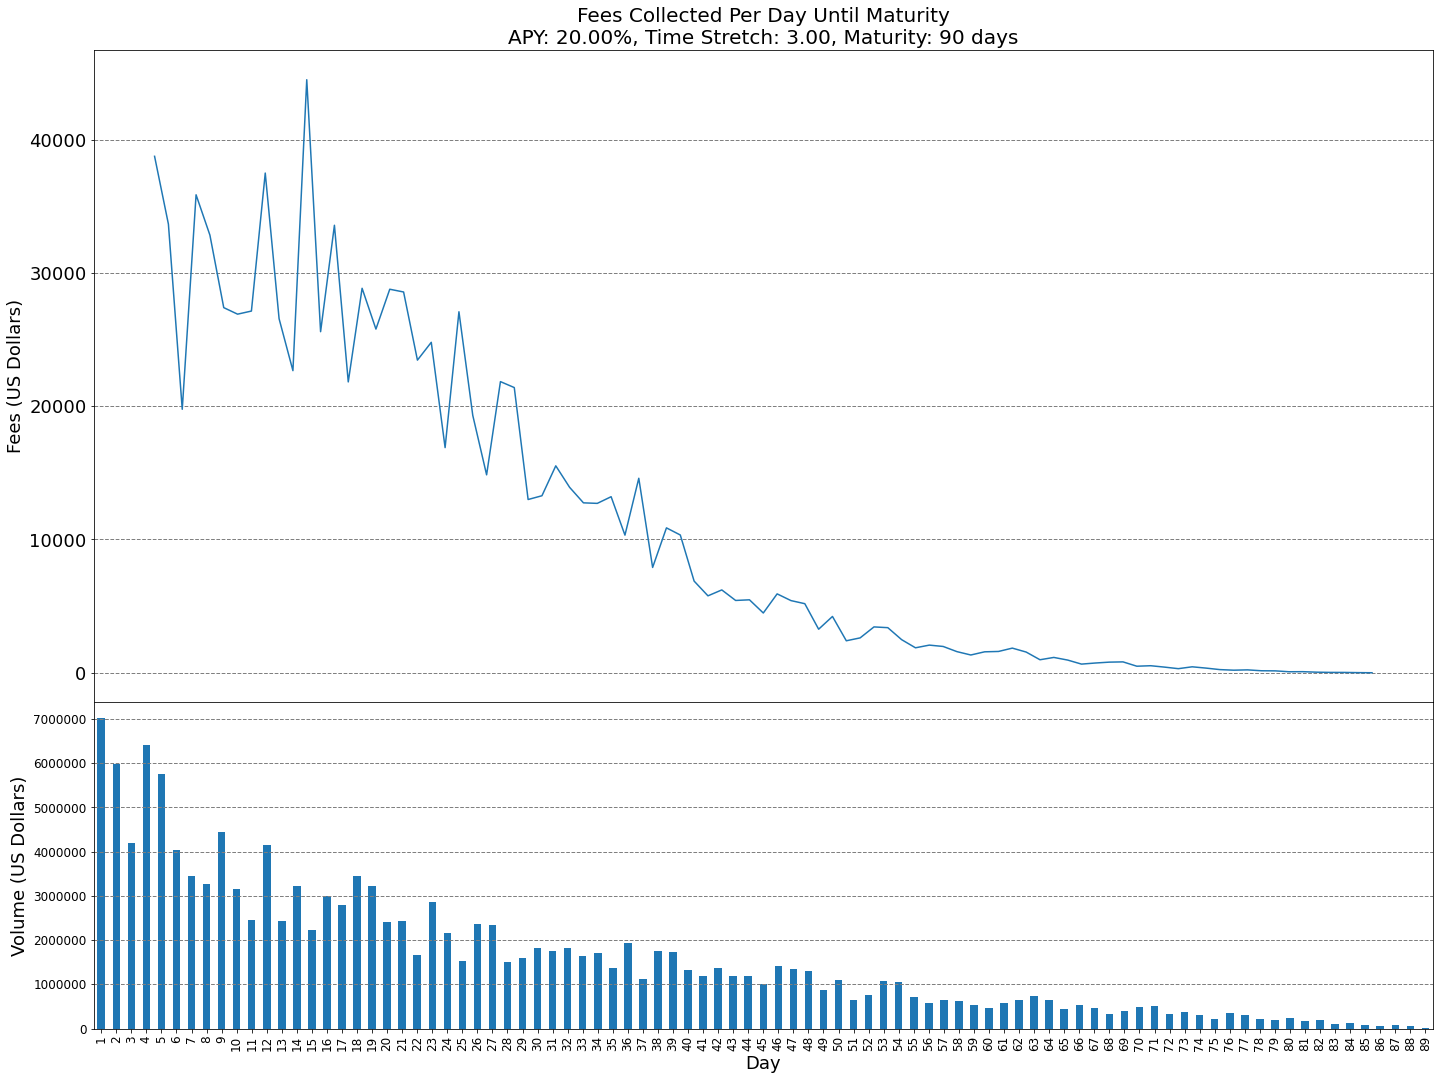

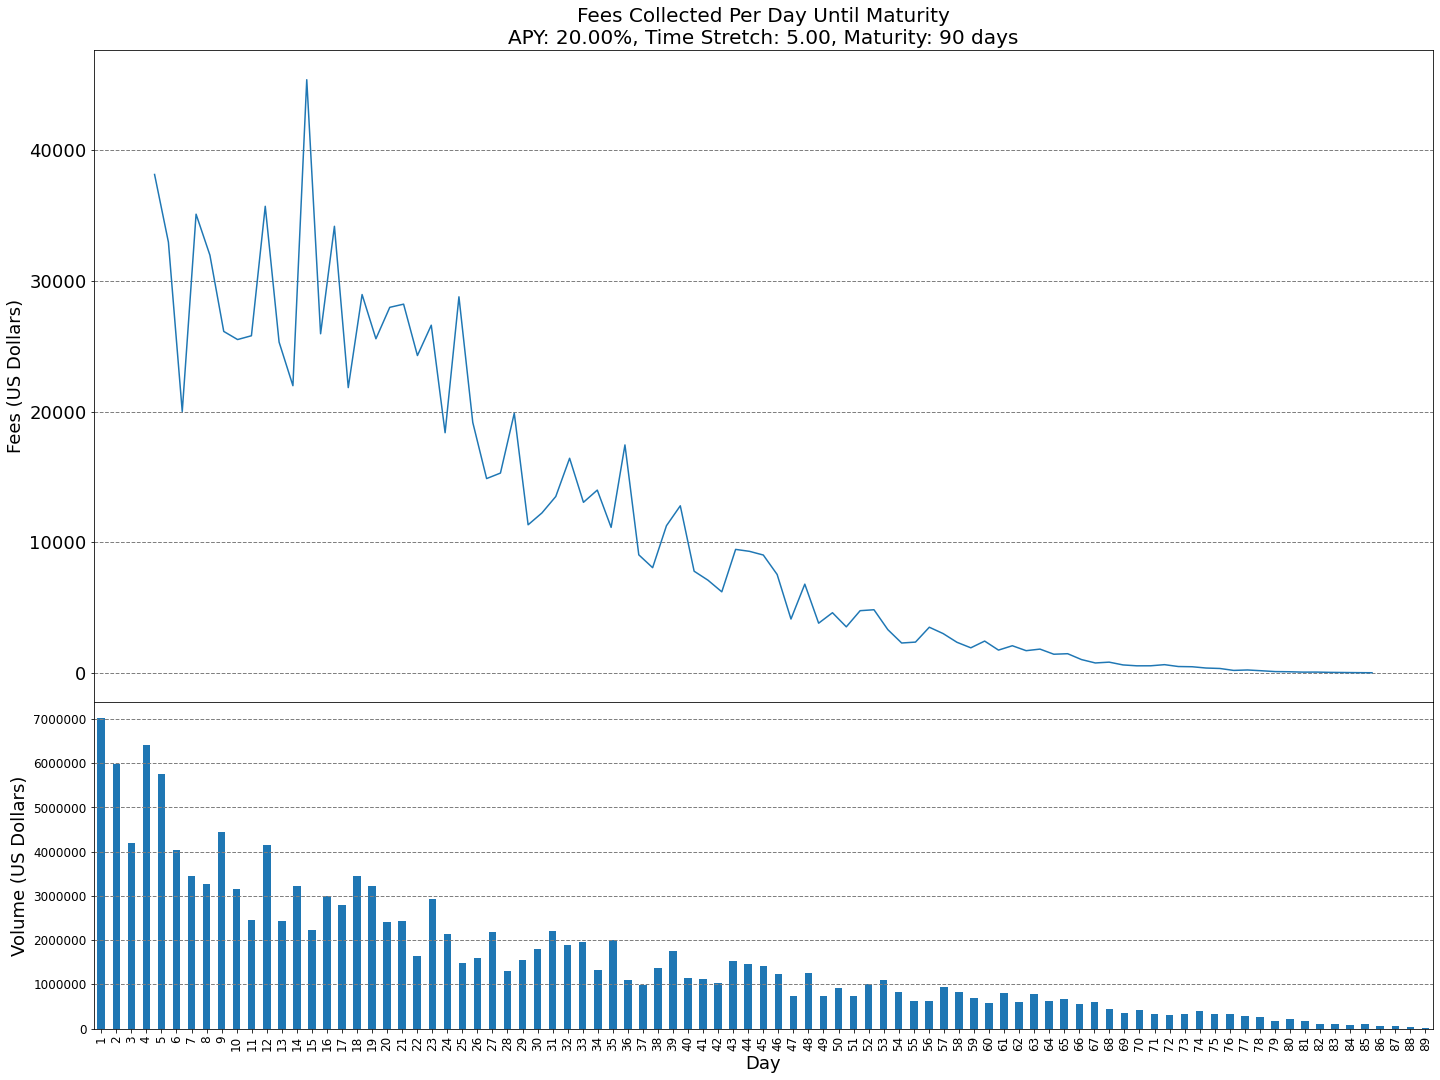

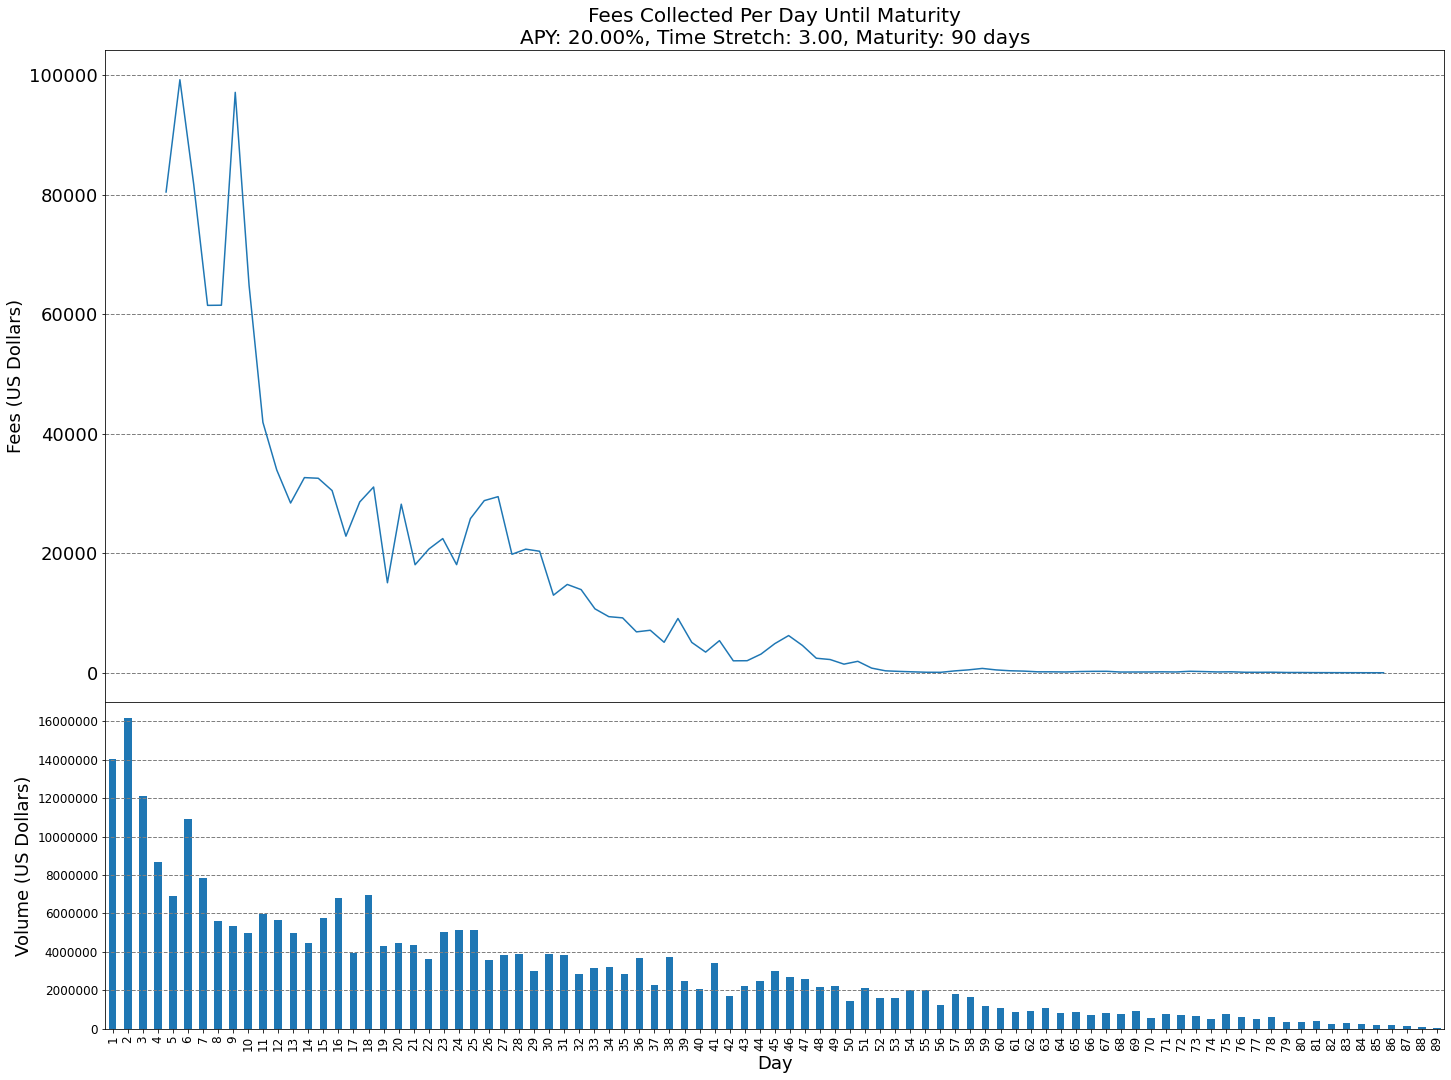

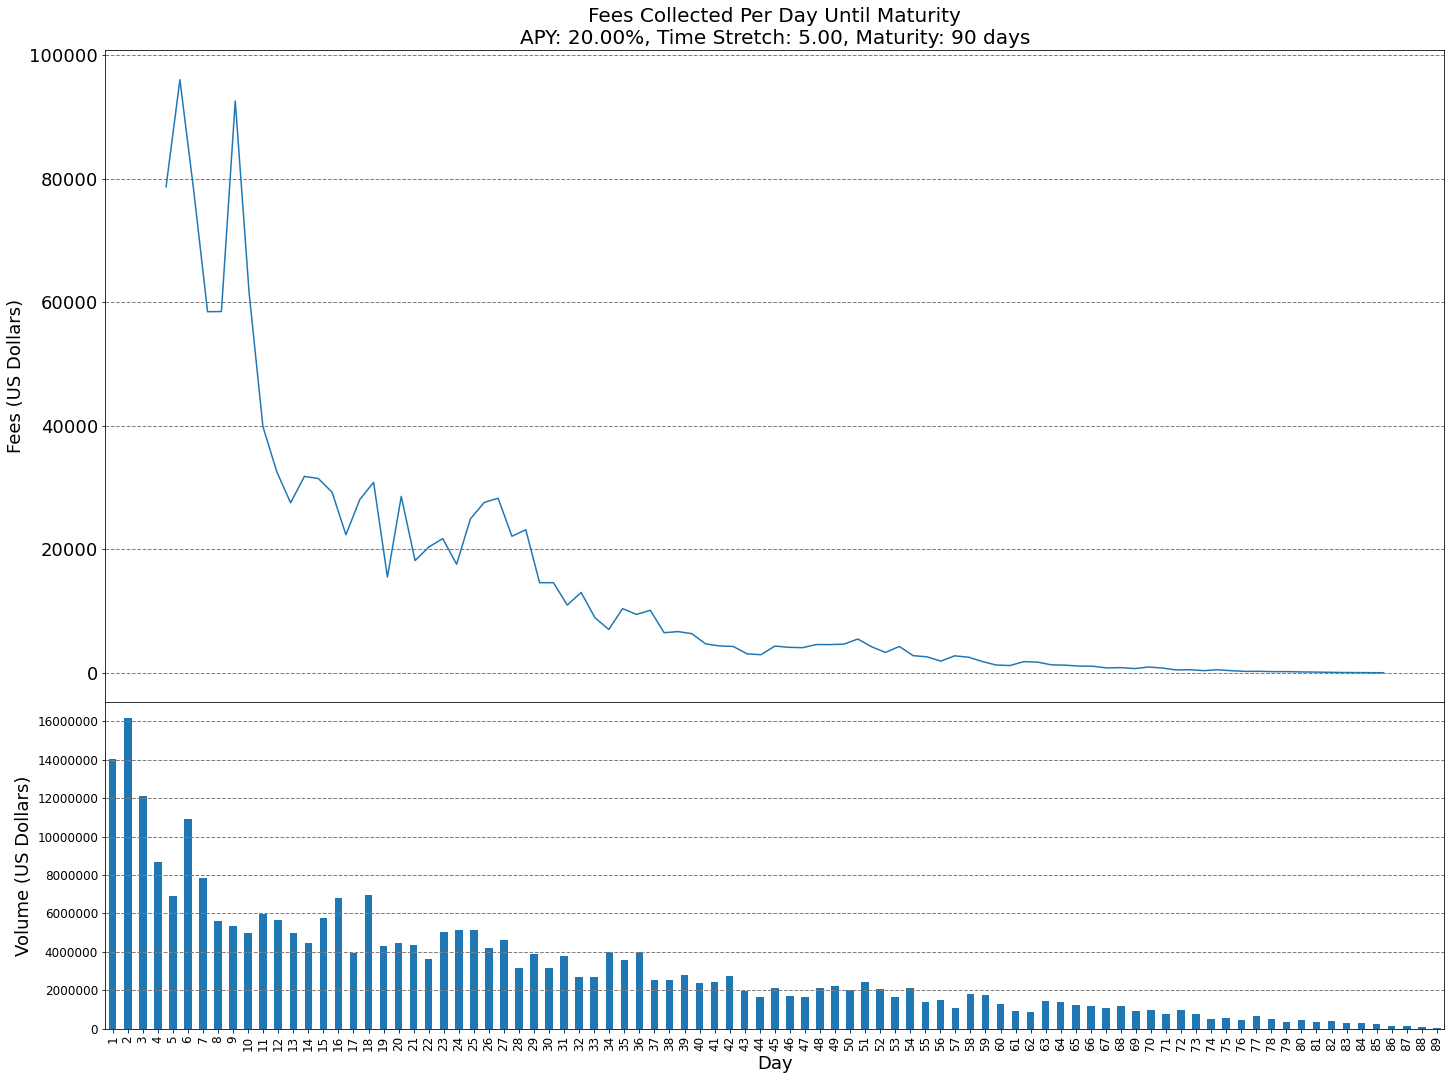

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

dfs=[]
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  dfs.append(df[ (df['init.market_price']==yba["market_price"]) & (df['init.time_stretch']==yba["time_stretch"]) & (df['init.apy']==yba["apy"]) & (df['init.percent_fee']==g) & (df['init.days_until_maturity']==yba["days_until_maturity"]) & (df['init.target_liquidity']==target_liquidity) & (df['init.target_daily_volume']==target_daily_volume)].reset_index())

for _df in dfs:
    fig, ax = plt.subplots(ncols=1, nrows=2,gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[2,1]})
    df_fees_volume = _df.groupby(['input.day']).agg({'output.trade_volume':['sum']\
                                   ,'output.fee':['mean','std','min','max','sum']\
                                  })
    df_fees_volume.columns = ['_'.join(col).strip() for col in df_fees_volume.columns.values]
    df_fees_volume = df_fees_volume.reset_index()
    ax[0] = df_fees_volume.plot(x="input.day", y="output.fee_sum",figsize=(24,18),ax=ax[0]);
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Fees (US Dollars)",fontsize=18)
    ax[0].tick_params(axis = "both", labelsize=18)
    ax[0].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[0].xaxis.set_ticklabels([])
    title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Time Stretch: {:.2f}, Maturity: {:} days".format(_df['init.apy'][0],_df['init.time_stretch'][0],_df['init.days_until_maturity'][0])
    ax[0].set_title(title,fontsize=20)
    ax[0].legend().set_visible(False)

    ax[1] = df_fees_volume.plot(kind='bar',x="input.day", y="output.trade_volume_sum",ax=ax[1]);
    ax[1].set_xlabel("Day",fontsize=18)
    ax[1].set_ylabel("Volume (US Dollars)",fontsize=18)
    ax[1].tick_params(axis = "both", labelsize=12)
    ax[1].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[1].legend().set_visible(False)
    ax[1].ticklabel_format(style='plain',axis='y')
    fig.subplots_adjust(wspace=None, hspace=None)

In [36]:
df_fees_volume

,input.day,output.trade_volume_sum,output.fee_mean,output.fee_std,output.fee_min,output.fee_max,output.fee_sum
0,1,"14,031,735.02728125",35.10856466,7.61013964,11.65534469,62.50864647,"78,713.40197513"
1,2,"16,174,417.27376247",37.12269944,8.36485155,12.73261386,68.95399799,"96,036.42345182"
2,3,"12,134,524.12385739",40.68959867,8.38846491,11.23359081,72.08682878,"78,042.65024796"
3,4,"8,689,779.99336921",41.97034020,9.02917517,13.73307053,86.32964732,"58,464.68389492"
4,5,"6,901,938.17023430",53.27616105,11.14166646,19.95843904,89.48924623,"58,497.22483772"
...,...,...,...,...,...,...,...
84,85,"223,133.31849352",2.14208117,0.42748791,1.06851407,3.12373918,77.11492206
85,86,"144,944.66063122",1.86324931,0.31718761,1.08842978,2.37782844,40.99148473
86,87,"131,847.30609868",1.40304172,0.36097206,0.74834198,2.24838921,29.46387620
87,88,"99,801.34423786",1.08657375,0.19472308,0.69302775,1.32977620,17.38517993


In [44]:
pd.options.display.float_format = '{:,.8f}'.format
df_fees_agg = df.groupby(['init.apy','init.percent_fee','init.time_stretch','init.market_price','init.target_liquidity','init.days_until_maturity','init.target_daily_volume']).agg({'output.fee':['count','sum'],'output.trade_volume':['sum'],'output.slippage':['mean'],'input.amount_specified':['mean']})
df_fees_agg.columns = ['_'.join(col).strip() for col in df_fees_agg.columns.values]
df_fees_agg = df_fees_agg.reset_index()
df_fees_agg['init.percent_fee'] = df_fees_agg['init.percent_fee'].round(2)
df_fees_agg['output.mean_daily_volume'] = df_fees_agg['output.trade_volume_sum']/df_fees_agg['init.days_until_maturity']
df_fees_agg['output.apr'] = (df_fees_agg['output.fee_sum']/df_fees_agg['init.target_liquidity']) * (365/df_fees_agg['init.days_until_maturity'])*100
df_fees_agg = df_fees_agg.drop(columns=['input.amount_specified_mean','init.percent_fee']).reset_index()
df_fees_agg

,index,init.apy,init.time_stretch,init.market_price,init.target_liquidity,init.days_until_maturity,init.target_daily_volume,output.fee_count,output.fee_sum,output.trade_volume_sum,output.slippage_mean,output.mean_daily_volume,output.apr
0,0,20,3,2000,5000000,90,5000000,22652,"982,304.14490142","141,826,144.93124336",0.67209118,"1,575,846.05479159",79.67578064
1,1,20,3,2000,5000000,90,10000000,43680,"1,247,067.29755423","273,475,666.30224246",0.20577624,"3,038,618.51446936",101.15101413
2,2,20,5,2000,5000000,90,5000000,22488,"1,001,825.75084001","140,737,160.93457299",2.99826229,"1,563,746.23260637",81.25919979
3,3,20,5,2000,5000000,90,10000000,44019,"1,259,106.33051523","275,467,097.47610110",1.29480915,"3,060,745.52751223",102.12751348


In [49]:
#df_fees_agg.to_csv("fees.csv")
df_fees_agg[['init.time_stretch','init.target_daily_volume','output.fee_sum','output.trade_volume_sum','output.mean_daily_volume','output.apr']]

,init.time_stretch,init.target_daily_volume,output.fee_sum,output.trade_volume_sum,output.mean_daily_volume,output.apr
0,3,5000000,"982,304.14490142","141,826,144.93124336","1,575,846.05479159",79.67578064
1,3,10000000,"1,247,067.29755423","273,475,666.30224246","3,038,618.51446936",101.15101413
2,5,5000000,"1,001,825.75084001","140,737,160.93457299","1,563,746.23260637",81.25919979
3,5,10000000,"1,259,106.33051523","275,467,097.47610110","3,060,745.52751223",102.12751348


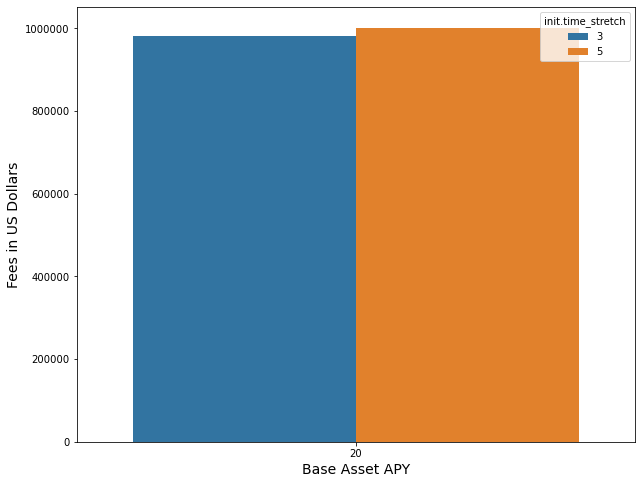

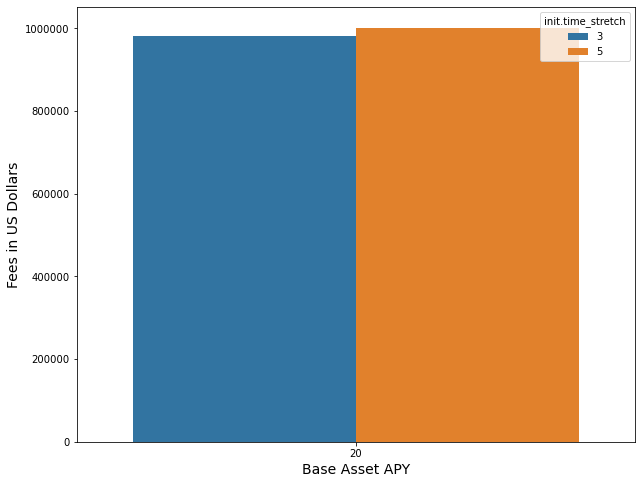

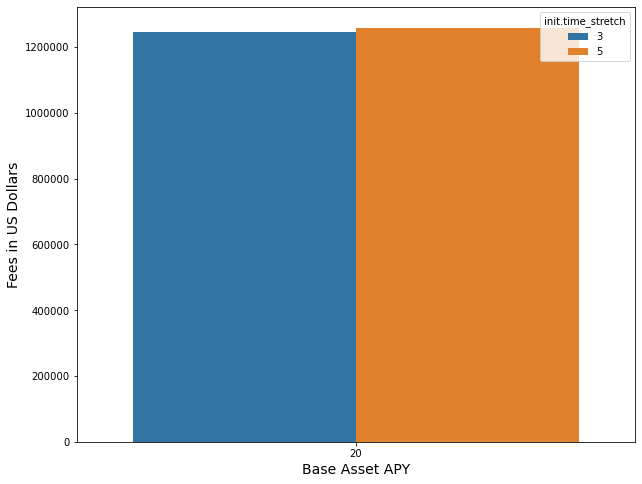

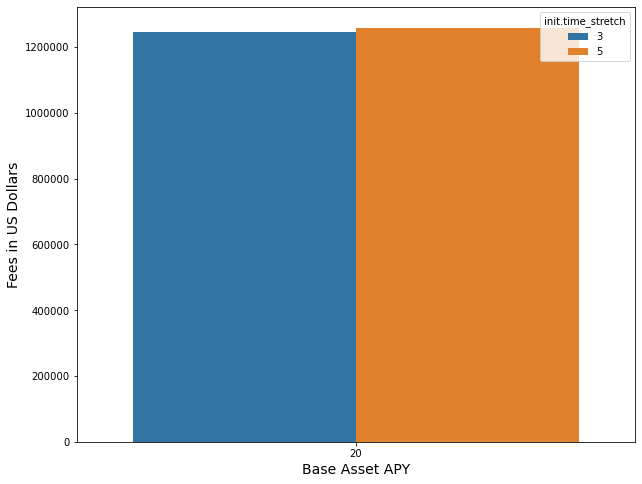

In [27]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

#plt.figure(figsize=(20, 20))
#for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
#condition = (df_fees_agg['init.market_price']==yba["market_price"]) & (df_fees_agg['init.days_until_maturity']==yba["days_until_maturity"]) & (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  plt.figure(figsize=(10, 8))
  condition =   (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
  sns.barplot(x="init.apy", 
              y="output.fee_sum", 
              hue="init.time_stretch", 
              data=df_fees_agg[condition],
              ci=None)
  plt.ticklabel_format(style='plain',axis='y')
  plt.ylabel("Fees in US Dollars", size=14)
  plt.xlabel("Base Asset APY", size=14)
  #title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Fee: {:.2f}%, Maturity: {:} days\nTarget Daily Volume: \${:,.2f}, Target Liquidity: \${:,.2f}".format(_df['init.apy'][0],_df['init.percent_fee'][0]*100,_df['init.days_until_maturity'][0],_df['init.target_daily_volume'][0],_df['init.target_liquidity'][0])
  #plt.title("Cumulative Fees for 30 day FYT\n"+"Target Volume = " + str(df_fees_agg[condition]['init.target_daily_volume'].iloc[0]) + "\nTarget Liquidity = " + str(df_fees_agg[condition]['init.target_liquidity'].iloc[0]), size=14)
